## MNIST

### Importando bibliotecas, carregando o dataset e visualizando as imagens

In [48]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import seaborn as sns
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import  cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
type(X)

pandas.core.frame.DataFrame

In [6]:
y.shape

(70000,)

In [7]:
type(y)

pandas.core.series.Series

In [8]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


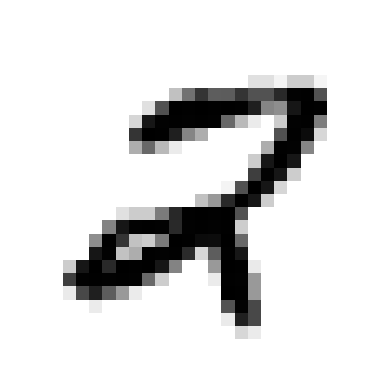

'2'

In [9]:
i = random.randint(0, len(y))
some_digit = X.iloc[i, :].to_numpy()
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
y[i]

In [10]:
y = y.astype(np.uint8)

In [11]:
def plot_images(images, y, number=1, figsize=(10, 5)):
    rows = math.ceil(math.sqrt(number))
    columns = math.ceil(number / rows)

    fig, axes = plt.subplots(rows, columns, figsize=figsize)

    axes = np.array(axes).reshape(rows, columns)

    for i in range(rows * columns):
        ax = axes.flat[i]
        if i < number:
            digit = images.iloc[i, :].to_numpy()
            digit_image = digit.reshape(28, 28)
            ax.imshow(digit_image, cmap="binary")
            ax.set_title(y[i])
        ax.axis("off") 
    plt.tight_layout()
    plt.show()

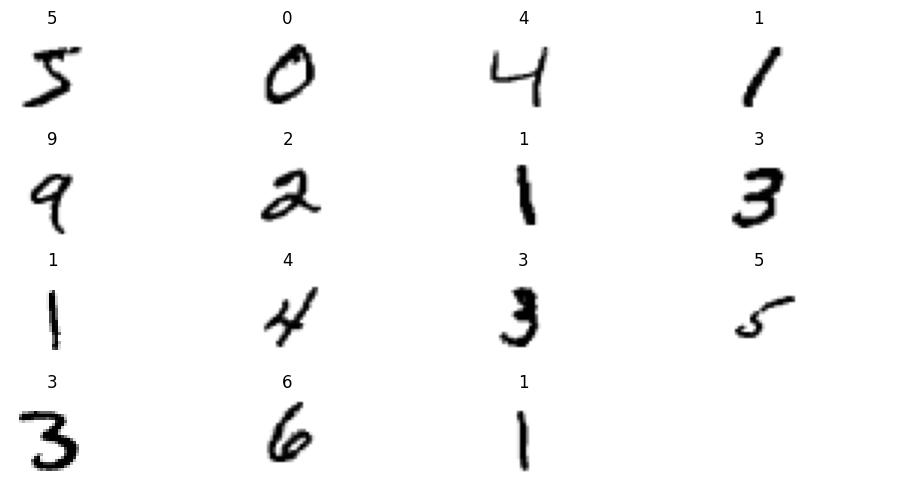

In [12]:
plot_images(X, y, 15)

### Separando o cojunto de dados em treinamento e teste

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Treinando um classificador binário para o digito '0'

In [14]:
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

In [15]:
sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_0)

SGDClassifier(random_state=42)

In [16]:
digit_0 = X.iloc[1, :].to_numpy()
sgd_classifier.predict([digit_0])

/home/rafa/projects/ml/mnist/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Cálculo de desempenho

In [17]:
skfolds = StratifiedKFold(n_splits=3, shuffle=False)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_classifier)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_0.iloc[train_index]

    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_0.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    predicts = clone_clf.predict(X_test_folds)
    n_correct = sum(predicts == y_test_folds)
    print(f"{n_correct / len(predicts):.4}")


0.9854
0.9847
0.9865


In [18]:
cross_val_score(sgd_classifier, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.9854, 0.9847, 0.9865])

In [19]:
class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

### Desempenho classificação dos não zero

In [20]:
never_0_clf = Never0Classifier()

In [24]:
cross_val_score(never_0_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.9003 , 0.9035 , 0.90005])

### Matriz de confusão

In [26]:
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_0, cv=3)

In [28]:
cm = confusion_matrix(y_train_0, y_train_pred)

In [31]:
cm

array([[53486,   591],
       [  277,  5646]])

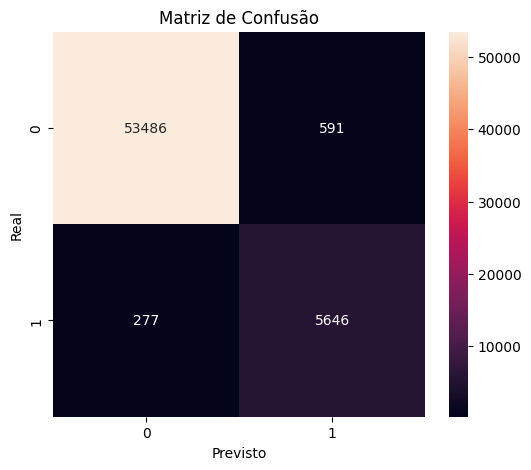

In [36]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### Precisão e Revocação

precisao = tp / tp + fp

renocação = tp / tp + fn

In [38]:
precision_score(y_train_0, y_train_pred)

0.9052429052429053

In [39]:
recall_score(y_train_0, y_train_pred)

0.9532331588721932

### f1 score

f1 = tp / (tp + ((fn + fp) / 2)) 

In [41]:
f1_score(y_train_0, y_train_pred)

0.9286184210526316

### Scores de decisão

In [42]:
y_scores = sgd_classifier.decision_function([digit_0])
y_scores

/home/rafa/projects/ml/mnist/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([21180.55082734])

In [44]:
threshold = 0
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

array([ True])

In [ ]:
# threshold = 30000
# y_some_digit_predict = (y_scores > threshold)
# y_some_digit_predict

array([False])

In [47]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_0, cv=3, method="decision_function")

In [57]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

In [59]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...]

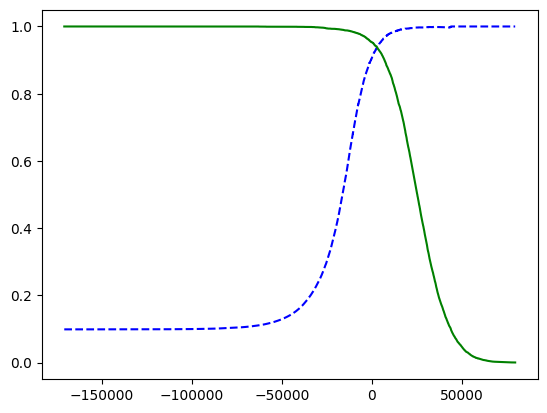

In [60]:
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
plt.show()

#### Aumentando a precisão

In [ ]:
threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]
threshold_95_precision

np.float64(4505.5537993279995)

In [ ]:
y_train_pred_95 = (y_scores >= threshold_95_precision)

In [ ]:
precision_score(y_train_0, y_train_pred_95)

0.9501039501039501

In [ ]:
recall_score(y_train_0, y_train_pred_95)

0.9258821543136924